# Kaggle Titanic
[데이터 다운로드](https://www.kaggle.com/competitions/titanic/data)


코드 부분은 지우고 결과 부분만 남겨 뒀습니다.  
남아있는 결과와 동일하게 출력될 수 있도록 코드를 작성해보세요!  

### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

### Data Load

In [2]:
train = pd.read_csv("data/train.csv", encoding="utf-8")
train.shape

(891, 12)

### 기본 정보

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 결측치 확인

<AxesSubplot:>

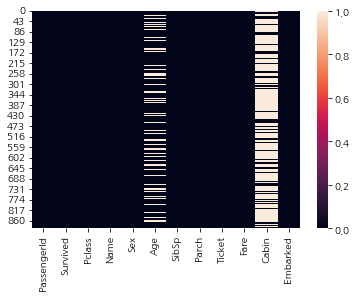

In [4]:
sns.heatmap(train.isnull())

In [5]:
train[['Age', 'Cabin', 'Embarked']].isnull().mean()

Age         0.198653
Cabin       0.771044
Embarked    0.002245
dtype: float64

### 생존자

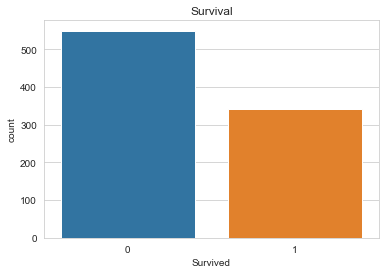

In [6]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='Survived')
plt.title('Survival')
plt.show()

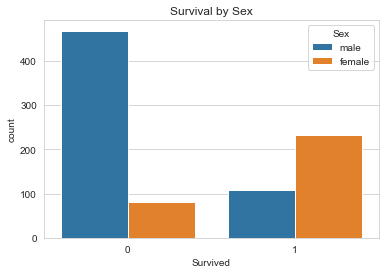

In [7]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='Survived', hue='Sex')
plt.title('Survival by Sex')
plt.show()

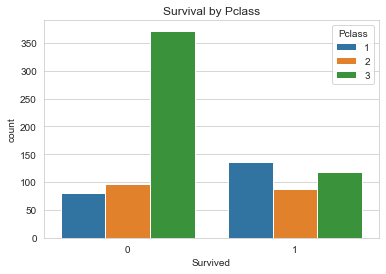

In [8]:
sns.set_style('whitegrid')
sns.countplot(data=train, x='Survived', hue='Pclass')
plt.title('Survival by Pclass')
plt.show()

### Data Cleaning
#### Age

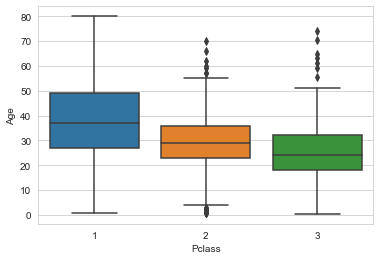

In [10]:
sns.set_style('whitegrid')
sns.boxplot(data=train, x='Pclass', y='Age')
plt.show()

In [11]:
train.groupby('Pclass')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


결측치가 있는 `Age`를 `Pclass`의 평균 나이값을 이용해 대채

In [13]:
def age_pclass(cols):
    Pclass_mean = train.groupby('Pclass')[cols].mean()
    train.loc[(train['Pclass']==1) & train[cols].isnull(), cols] = Pclass_mean[1]
    train.loc[(train['Pclass']==2) & train[cols].isnull(), cols] = Pclass_mean[2]
    train.loc[(train['Pclass']==3) & train[cols].isnull(), cols] = Pclass_mean[3]
    return train[cols]

In [14]:
# age_pclass 함수를 이용해 Age 결측치 채우기
age_pclass('Age')

0      22.00000
1      38.00000
2      26.00000
3      35.00000
4      35.00000
         ...   
886    27.00000
887    19.00000
888    25.14062
889    26.00000
890    32.00000
Name: Age, Length: 891, dtype: float64

#### 범주형 데이터 변환

범주형 데이터는 학습에서 바로 사용이 불가능하기 때문에 수치형으로 변환이 필요합니다.  
예를 들어, `Sex`의 경우 `Male=0`, `Female=1`과 같이 변환을 합니다.

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


현재 범주형 데이터는, `Name, Sex, Ticket, Embarked`가 있음

#### pd.get_dummies
학습 이전에 모든 데이터를 수치로 변환해주는 전처리 작업이 필요함  
1. 수치형 데이터로 변환
2. 수치화된 데이터를 가변수화

##### Note!!! - 가변수화
수치형 데이터로만 변환하면, **서로 간의 관계성**이 생기게 되어버림
- 월, 화, 수 ... -> 1, 2, 3 ...
- 1+2=3 / 월+화=수라는 관계성이 성립해버림

`pandas`의 `get_dummies` 함수는 원핫인코딩을 이용하는 방식  
`get_dummies(data=, prefix=, prefix_sep=, dummy_na=, columns=, drop_first=, dtype=)` 형식으로 존재함
- data: one-hot encoding을 적용할 데이터
- prefix: 생성할 더미 데이터(가변수화된 데이터)의 컬럼 prefix
- prefix_sep: `default='_'`
- dummpy_na: `NaN`도 포함시킬지, `default=False`
- columns: 대상 컬럼
- drop_first: k개의 범주를 k-1개로 가변수화할 경우 사용
- dtype: 새로운 columns의 데이터 타입

In [23]:
train['male'] = pd.get_dummies(train['Sex'], drop_first=True)

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


In [28]:
train[['Q','S']] = pd.get_dummies(train['Embarked'], drop_first=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0


In [32]:
train = train.drop(columns=['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1
